In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install torch-lr-finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 4.7 MB/s 
     |████████████████████████████████| 7.6 MB 81.2 MB/s 
     |████████████████████████████████| 163 kB 89.8 MB/s 


In [ ]:
pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 148 kB 4.8 MB/s 


In [ ]:
pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.7 MB/s 


In [ ]:
pip install torch-lr-finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import AutoModel
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from transformers import DataCollatorWithPadding
from torch_lr_finder import LRFinder
import gc

from accelerate import Accelerator

import os
os.environ["TOKENIZERS_PARALLELISM"] = 'false'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Config

In [ ]:
config = {
    'model' : 'microsoft/deberta-v3-base',
    'dropout' : 0.4,
    'max_length' : 512,
    'batch_size' : 16,
    'epochs' : 50,
    'lr' : 3e-5,
    'enable_scheduler' : True,
    'scheduler' : 'CosineAnnealingWarmRestarts',
    'gradient_accumulation_steps' : 2,
    'adam_eps' : 1e-6,
    'freeze_encoder' : False,
    'trn_fold': [0, 1, 2, 3],
    'target_cols' : ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'],
    'lr_patience' : 7,
}

# Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(config['model'])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Import Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ㄱ/train.csv')#.iloc[:100,:]
test_df = pd.read_csv('/content/drive/MyDrive/ㄱ/test.csv')
print('Train DataFrame:', df.shape, 'Test DataFrame:', test_df.shape)
print('Train columns name:',df.columns.to_list())

Train DataFrame: (3911, 8) Test DataFrame: (3, 2)
Train columns name: ['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']


# Dataset

In [ ]:
class Dataset: 
    def __init__(self, df, config, tokenizer=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.classes = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
        self.max_len = config['max_length']
        self.tokenizer = tokenizer
        self.is_test = is_test
    def __getitem__(self, idx):
        sample = self.df['full_text'][idx]
        tokenized = tokenizer.encode_plus(sample,
                                         None,
                                         add_special_tokens=True,
                                         max_length = self.max_len,
                                         truncation=True,
                                         padding='max_length')
        inputs = {
            'input_ids' : torch.tensor(tokenized['input_ids'], dtype=torch.long),
            'token_type_ids' : torch.tensor(tokenized['token_type_ids'], dtype=torch.long),
            'attention_mask' : torch.tensor(tokenized['attention_mask'], dtype=torch.long)
        }
        
        if self.is_test == True:
            return inputs
        
        label = self.df.loc[idx, self.classes].to_list()
        targets = {
            "labels" : torch.tensor(label, dtype=torch.float32),
        }
        
        return inputs, targets
    
    def __len__(self):
        return len(self.df)

# train_test_split

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=1357, shuffle=True)
print('Dataframe shapes :', train_df.shape, val_df.shape)

Dataframe shapes : (3128, 8) (783, 8)


# DataLoader

In [ ]:
train_ds = Dataset(train_df, config, tokenizer=tokenizer)
val_ds = Dataset(val_df, config, tokenizer=tokenizer)
test_ds = Dataset(test_df, config, tokenizer=tokenizer, is_test=True)

In [ ]:
train_ds[0][0].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=config['batch_size'], shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
print('loader shapes:',len(train_loader), len(val_loader))

loader shapes: 196 49


# Pooling

In [ ]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

# Model

In [ ]:
class DebertaModel(nn.Module):
    def __init__(self, config, num_classes=6):
        super(DebertaModel, self).__init__()
        self.model_name = config['model']
        self.freeze = config['freeze_encoder']
        
        self.encoder = AutoModel.from_pretrained(self.model_name)
        #if self.freeze:
        #    for param in self.encoder.base_model.parameters():
        #        param.requires_grad = False
                
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(config['dropout'])
        self.fc1 = nn.Linear(self.encoder.config.hidden_size, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, num_classes)
        
    def forward(self, inputs):
        outputs = self.encoder(**inputs, return_dict=True)
        outputs = self.pooler(outputs['last_hidden_state'], inputs['attention_mask'])
        outputs = self.fc1(outputs)
        outputs = self.fc2(outputs)
        outputs = self.fc3(outputs)
        return outputs

In [ ]:
# import EarlyStopping
# from pytorchtools import EarlyStopping
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Trainer

In [ ]:
class Trainer:
    def __init__(self, model, loaders, config, accelerator):
        self.model = model
        self.train_loader , self.val_loader = loaders
        self.config = config
        self.input_keys = ['input_ids', 'token_type_ids', 'attention_mask']
        self.accelerator = accelerator
        self.optim = self._get_optim()
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optim, T_0=5, eta_min = 1e-7)
        self.train_losses = []
        self.val_losses = []
        
    def prepare(self):
        self.model, self.optim, self.train_loader, self.val_loader, self.schduler = self.accelerator.prepare(
            self.model,
            self.optim,
            self.train_loader,
            self.val_loader,
            self.scheduler
        )
    def _get_optim(self):
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters=[
            {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=self.config['lr'], eps=self.config['adam_eps'])
        return optimizer
    
    def loss_fn(self, outputs, targets):
        colwise_mse = torch.mean(torch.square(targets - outputs), dim=0)
        loss = torch.mean(torch.sqrt(colwise_mse), dim=0)
        return loss
    
    def train_one_epoch(self,epoch):
        running_loss = 0.
        progress = tqdm(self.train_loader, total=len(self.train_loader))
        
        for idx, (inputs, targets) in enumerate(progress):
            with self.accelerator.accumulate(self.model):
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, targets['labels'])
                running_loss += loss.item()
                
                self.accelerator.backward(loss)
                
                self.optim.step()
                
                if self.config['enable_scheduler']:
                    self.scheduler.step(epoch-1 + idx / len(self.train_loader))
                
                self.optim.zero_grad()
                
                del inputs, targets, outputs, loss
                
        train_loss = running_loss/len(self.train_loader)
        self.train_losses.append(train_loss)
        
    @torch.no_grad()
    def valid_one_epoch(self, epoch):
        running_loss = 0.
        progress = tqdm(self.val_loader, total=len(self.val_loader))
        for (inputs, targets) in progress:
            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, targets['labels'])
            running_loss += loss.item()
            self.accelerator.backward(loss)
            self.optim.step()
            
            if self.config['enable_scheduler']:
                self.sheduler.step(epoch -1 + idx/len(self.train_loader))
                
            self.optim.zero_grad()
            
            del inputs, targets, outputs, loss
            
        train_loss = running_loss/len(self.train_loader)
        self.train_losses.append(train_loss)
        
    @torch.no_grad()
    def valid_one_epoch(self,epoch):
        running_loss = 0.
        progress = tqdm(self.val_loader, total = len(self.val_loader))
        
        for (inputs, targets) in progress:
            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, targets['labels'])
            running_loss += loss.item()
            del inputs, targets, outputs, loss
            
        val_loss = running_loss/len(self.val_loader)
        self.val_losses.append(val_loss)
        
    def test(self, test_loader):
        
        preds = []
        for (inputs) in test_loader:
            outputs = self.model(inputs)
            preds.append(outputs.detach().cpu())
            
        preds = torch.concat(preds)
        return preds
    
    def fit(self):
        self.prepare()
        fit_progress = tqdm(
            range(1, self.config['epochs']+1),
            leave = True,
            desc = "Training..."
        )
        self.early_stopping = EarlyStopping(patience = self.config['lr_patience'], verbose = True)

        for epoch in fit_progress:
            self.model.train()
            fit_progress.set_description(f"EPOCH {epoch} / {self.config['epochs']} | training...")
            self.train_one_epoch(epoch)
            self.clear()
            
            self.model.eval()
            fit_progress.set_description(f"EPOCH {epoch} / {self.config['epochs']} | validating...")
            self.valid_one_epoch(epoch)
            self.clear()

            print(f"{'➖️'*10} EPOCH {epoch} / {self.config['epochs']} {'➖️'*10}")
            print(f"train loss: {self.train_losses[-1]}")
            print(f"valid loss: {self.val_losses[-1]}\n\n")

            self.early_stopping(self.val_losses[-1], self.model)
            
            if self.early_stopping.early_stop:
              print("Early stopping")
              break
            
    def get_model(self):
        # best model이 저장되어있는 last checkpoint를 로드한다.
        self.model.load_state_dict(torch.load('checkpoint.pt'))

        return self.model

    def clear(self):
        gc.collect()
        torch.cuda.empty_cache()


# Accelerate

In [ ]:
accelerator = Accelerator(gradient_accumulation_steps=config['gradient_accumulation_steps'])

In [ ]:
model = DebertaModel(config).to(device=accelerator.device)
trainer = Trainer(model, (train_loader, val_loader), config, accelerator)

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
trainer.fit()

Training...:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 1 / 50 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.9580161287164202
valid loss: 0.495416735508004


Validation loss decreased (inf --> 0.495417).  Saving model ...


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 2 / 50 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5000190137296306
valid loss: 0.5151643795626504


EarlyStopping counter: 1 out of 7


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 3 / 50 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.4676398370338946
valid loss: 0.5687650204921255


EarlyStopping counter: 2 out of 7


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 4 / 50 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.44750957966459043
valid loss: 0.5923541820779139


EarlyStopping counter: 3 out of 7


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 5 / 50 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.43670071631061785
valid loss: 0.5983788681273557


EarlyStopping counter: 4 out of 7


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 6 / 50 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.45658628353658987
valid loss: 0.5933161469138398


EarlyStopping counter: 5 out of 7


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 7 / 50 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.4360268625373743
valid loss: 0.49814486686064274


EarlyStopping counter: 6 out of 7


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 8 / 50 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.4132796761636831
valid loss: 0.5930544435977936


EarlyStopping counter: 7 out of 7
Early stopping


# Result

In [ ]:
model = trainer.get_model()

In [ ]:
list(range(1, config['lr_patience']+2))

[1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
losses_df = pd.DataFrame({
                          'train_loss':trainer.train_losses, 
                          'val_loss':trainer.val_losses,
                         })
losses_df.index = losses_df.index+1

In [ ]:
losses_df

,train_loss,val_loss
1,0.958016,0.495417
2,0.500019,0.515164
3,0.467640,0.568765
4,0.447510,0.592354
5,0.436701,0.598379
6,0.456586,0.593316
7,0.436027,0.498145
8,0.413280,0.593054


# Plot

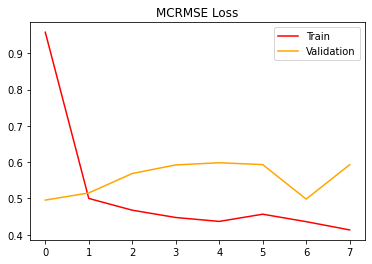

In [ ]:
plt.plot(trainer.train_losses, color='red')
plt.plot(trainer.val_losses, color='orange')
plt.title('MCRMSE Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Inference

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/ㄱ/test.csv")
submission = pd.read_csv("/content/drive/MyDrive/ㄱ/sample_submission.csv")
df_INNER_JOIN = pd.merge(test_df, submission, left_on='text_id', right_on='text_id', how='inner')
test_df = df_INNER_JOIN
test_df

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,when a person has no experience on a job their...,3.0,3.0,3.0,3.0,3.0,3.0
1,000BAD50D026,Do you think students would benefit from being...,3.0,3.0,3.0,3.0,3.0,3.0
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",3.0,3.0,3.0,3.0,3.0,3.0


In [ ]:
def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [ ]:
test_loader = DataLoader(test_ds,
                         batch_size=config['batch_size'],
                         shuffle=False, num_workers=2, pin_memory=True)
predictions = []
for fold in range(5):
    # model = DebertaModel(config)
    # state = torch.load('checkpoint.pt',
    #                    map_location=torch.device('cpu'))
    #model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader, model, device)
    predictions.append(prediction)
    del prediction; gc.collect()
    torch.cuda.empty_cache()
predictions = np.mean(predictions, axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:746: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale, dtype=query_layer.dtype
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  score += c2p_att / torch.tensor(scale, dtype=c2p_att.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:852: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  score += p2c_att / to

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
predictions 

array([[2.8194113, 2.6781492, 3.0055861, 2.840015 , 2.633072 , 2.7219334],
       [2.681778 , 2.538161 , 2.90148  , 2.715079 , 2.5197413, 2.5859568],
       [3.2477524, 3.1192133, 3.3606782, 3.2624373, 3.0609102, 3.1937187]],
      dtype=float32)

In [ ]:
test_df[config['target_cols']] = predictions
test_df

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,when a person has no experience on a job their...,2.819411,2.678149,3.005586,2.840015,2.633072,2.721933
1,000BAD50D026,Do you think students would benefit from being...,2.681778,2.538161,2.901480,2.715079,2.519741,2.585957
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",3.247752,3.119213,3.360678,3.262437,3.060910,3.193719
